do the clusters for different topic number (20 & 24) and for different lenghts dropped (5, 20)

In [82]:
#import gensim for topic modelling
import gensim # https://radimrehurek.com/gensim/models/ldamodel.html
from gensim import corpora
from gensim.models import CoherenceModel #to calculate coherence
import time #to have today's date
timestr = time.strftime("%Y%m%d")
import pandas as pd
from scipy.spatial import distance_matrix
import sklearn
import scipy.cluster.hierarchy as shc # for dendrogram
var_text_size = 15 #for font size in graphs

In [1]:
#get the clean text from the other notebook
%run ./p_03_prepare_text_paper.ipynb
# doc_clean = get_doc_clean() ##all interviews together
#dict_clean_doc_x ##with different lenghts dropped

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

Bad key text.latex.preview in file c:\users\mann\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\users\mann\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplot

In [107]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
def get_dictionary(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    return(dictionary)

In [108]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
#this is also called Bag of Words corpus
def get_doc_term_matrix(dictionary, doc_clean):
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return(doc_term_matrix)

In [109]:
# do dictionaries with different parameter values
#different number of topics
dict_18_10 = {'var_no_topics':18, 'var_drop_x':10}
dict_20_10 = {'var_no_topics':20, 'var_drop_x':10}
dict_22_10 = {'var_no_topics':22, 'var_drop_x':10}
dict_24_10 = {'var_no_topics':24, 'var_drop_x':10}
dict_26_10 = {'var_no_topics':26, 'var_drop_x':10}
#different corpus (dropped documents)
dict_22_5 = {'var_no_topics':22, 'var_drop_x':5}
dict_22_20 = {'var_no_topics':22, 'var_drop_x':20}


# do dictionary for the different LDA runs
dict_dict_runs = {'18_10':dict_18_10, '20_10':dict_20_10, '22_10':dict_22_10, '24_10':dict_24_10, '26_10':dict_26_10,\
                 '22_5':dict_22_5, '22_20':dict_22_20 }

In [110]:
dict_dictionary_runs = {}
dict_doc_term_matrix_runs = {}

for runs in dict_dict_runs:
    var_drop_x = dict_dict_runs[runs]['var_drop_x']
    doc_clean_run = dict_clean_doc_x['>'+str(var_drop_x)]  #from p_03_prepare text
    doc_list_paras_run = dict_doc_list_paras_x['>'+str(var_drop_x)] #from p_03_prepare text
    
    #create dictionaries
    dictionary_run = get_dictionary(doc_clean_run)
    dict_dictionary_runs[runs] = dictionary_run
    #get document term matrix
    doc_term_matrix_run = get_doc_term_matrix(dictionary_run, doc_clean_run)
    dict_doc_term_matrix_runs[runs] = doc_term_matrix_run

## run the LDA

In [111]:
# Creating the object for LDA model using gensim library + # Running and Trainign LDA model on the document term matrix.
def get_ldamodel(var_alpha, var_no_topics, var_passes, doc_term_matrix, dictionary):
    ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=var_no_topics, alpha=var_alpha,
                id2word = dictionary, random_state=1, passes=var_passes,minimum_probability=0) 
    #use random_state for reproducity
    return(ldamodel)

In [112]:
n = 0
dict_LDA_runs = {} #create dictionary for the model runs
for runs in dict_dict_runs:
    var_drop_x = dict_dict_runs[runs]['var_drop_x']

    dictionary_run =  dict_dictionary_runs[runs]
    doc_term_matrix_run = dict_doc_term_matrix_runs[runs]
    
    #choose parameters, run model:
    var_alpha = 0.01
    var_no_topics = dict_dict_runs[runs]['var_no_topics']
    var_passes = 50 # default: passes=1
    ldamodel = get_ldamodel(var_alpha, var_no_topics, var_passes, doc_term_matrix_run, dictionary_run)
    dict_LDA_runs[runs] = ldamodel

    n+=1
    print('done with no '+str(n)+'; topics='+str(var_no_topics)+' and >'+str(var_drop_x))


done with no 1; topics=18 and >10
done with no 2; topics=20 and >10
done with no 3; topics=22 and >10
done with no 4; topics=24 and >10
done with no 5; topics=26 and >10
done with no 6; topics=22 and >5
done with no 7; topics=22 and >20


## get overview of topics

In [113]:
#do list with the topics keywords for graphs
dict_keywords_runs = {} #create dict for the keywords for each run
for runs in dict_dict_runs:
    list_topics_keywords = list()
    for x in range(0, dict_dict_runs[runs]['var_no_topics']):
        wp = dict_LDA_runs[runs].show_topic(x, topn=10) #default: topn=10, number of words
        topic_keywords = ", ".join([word for word, prop in wp])
        list_topics_keywords.append(topic_keywords)
    dict_keywords_runs[runs] = list_topics_keywords

## get contribution from each topic for each document, i.e. master df (from p_13)

In [114]:
dict_topics_per_doc_df_runs = {}
n=0
for runs in dict_dict_runs:    
    var_drop_x = dict_dict_runs[runs]['var_drop_x']
    ldamodel_run = dict_LDA_runs[runs]
    var_no_topics_run = dict_dict_runs[runs]['var_no_topics']
    doc_list_paras_run = dict_doc_list_paras_x['>'+str(var_drop_x)]
    doc_term_matrix_run =  dict_doc_term_matrix_runs[runs]
    
    #create dataframe with empty columns
    topics_per_doc_df_run = pd.DataFrame()
    list_topics_columns_run = list() #to use later
    for x in range(0,var_no_topics_run):
        topics_per_doc_df_run["perc_cont_"+str(x)] = []
        list_topics_columns_run.append("perc_cont_"+str(x))
        
    # Get relevant topics for each document, this takes a while
    for i, row in enumerate(ldamodel_run[doc_term_matrix_run]): #this provides a list with all topics and their percentage contribution
        # Get all the topics, Perc Contribution and Keywords for each document
        for j in row:
            topic_num = j[0]
            prop_topic = j[1]
            wp = ldamodel_run.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            topics_per_doc_df_run.loc[i, "perc_cont_"+str(topic_num)] = prop_topic
            topics_per_doc_df_run.loc[i, "keywords_"+str(topic_num)] = topic_keywords    
    
    # Add original text to the end of the output to merge on
    contents = pd.Series(doc_list_paras_run)
    topics_per_doc_df_run = pd.concat([topics_per_doc_df_run, contents], axis=1)
    topics_per_doc_df_run.rename(columns={0:'Text'}, inplace=True) #rename the added column with the original text
    df_docs_topics_run = topics_per_doc_df_run
    
    #merge to get information on country, class etc. for each document
    df_docs_topics_country_class_run = df_all_interviews.merge(df_docs_topics_run)
    #S: drop duplicate rows:
    df_docs_topics_country_class_run = df_docs_topics_country_class_run.drop_duplicates().reset_index(drop=True)
    
    dict_topics_per_doc_df_runs[runs] = df_docs_topics_country_class_run
    n+=1
    print('done with no '+str(n)+'; topics='+str(var_no_topics)+' and >'+str(var_drop_x))


done with no 1; topics=22 and >10
done with no 2; topics=22 and >10
done with no 3; topics=22 and >10
done with no 4; topics=22 and >10
done with no 5; topics=22 and >10
done with no 6; topics=22 and >5
done with no 7; topics=22 and >20


normally: change topic numbers to new numbers after labelling & assigning to categories

## get the topic contribution per country (from p_14)

In [115]:
#order of countries: (based on country hierarchical clustering)
list_country_oder = ['DE', 'UK', 'CL', 'CO', 'US', 'KE', 'ZA', 'ID', 'IN', 'VN', 'PH', 'PK']

In [116]:
dict_df_country_topics_share_runs = {}
n=0
for runs in dict_dict_runs:    
    var_drop_x = dict_dict_runs[runs]['var_drop_x']
    ldamodel_run = dict_LDA_runs[runs]
    var_no_topics_run = dict_dict_runs[runs]['var_no_topics']
    doc_list_paras_run = dict_doc_list_paras_x['>'+str(var_drop_x)]
    doc_term_matrix_run =  dict_doc_term_matrix_runs[runs]
    
    df_docs_topics_country_class_run = dict_topics_per_doc_df_runs[runs]
    
    #create list with all columns that should be added to the sum
    list_all_columns = df_docs_topics_country_class_run.columns
    list_to_sum_run = []
    for x in list_all_columns:
        if 'perc_cont' in x:
            list_to_sum_run.append(x)
            
    #show the topics per country
    df_topics_country_gr_run = df_docs_topics_country_class_run.copy().\
        groupby(['Country'])[list_to_sum_run].sum().reset_index()

    #change order of countries
    df_topics_country_gr_run = df_topics_country_gr_run.set_index('Country').reindex(list_country_oder).reset_index()

    #create column with the sum of all percentages, e.g. the number of paragraphs (not 100%, because rounded)
    df_topics_country_gr_run['perc_total'] = df_topics_country_gr_run[list_to_sum_run].sum(axis=1)

    #make list with all the columns (to delete later on)
    list_topics_columns_paras_run = list_to_sum_run.copy()
    list_topics_columns_paras_run.append('perc_total')

    #get for each country the percentage for each topic
    #example: documents from country A consist to 10% of topic 1, to 60% topic 2, and 30% topic 3.
    #now the dataframe has the percentage for each topic. Divide by the number of texts per country. 
    df_country_topics_share_run = df_topics_country_gr_run.copy()
    for x in df_country_topics_share_run.index:
        for y in list_to_sum_run:
            var_number = df_country_topics_share_run.loc[x,y]/df_country_topics_share_run.loc[x,'perc_total']*100
            df_country_topics_share_run.loc[x, y+'_total'] = round(var_number,1)

    #drop and rename columns
    col_n = 1
    for x in list_topics_columns_paras_run:
        df_country_topics_share_run.drop(columns={x}, inplace=True)
        df_country_topics_share_run.rename(columns={x+'_total':col_n}, inplace=True)
        col_n+=1
        
    dict_df_country_topics_share_runs[runs] = df_country_topics_share_run
    n+=1
    print('done with no '+str(n)+'; topics='+str(var_no_topics)+' and >'+str(var_drop_x))

done with no 1; topics=22 and >10
done with no 2; topics=22 and >10
done with no 3; topics=22 and >10
done with no 4; topics=22 and >10
done with no 5; topics=22 and >10
done with no 6; topics=22 and >5
done with no 7; topics=22 and >20


## create distance matrix (from p_19)

In [117]:
dict_distance_p1_runs = {}

for runs in dict_dict_runs:    
    df_country_topics_share_run = dict_df_country_topics_share_runs[runs] 
    #so here we have 12 vectors (countries) with 22 dimensions (topics) 
    df_c_s_run = df_country_topics_share_run.set_index('Country')
    
    df_distance_p1_run =  pd.DataFrame(distance_matrix(df_c_s_run.values, df_c_s_run.values, p=1), index=df_c_s_run.index, columns=df_c_s_run.index)
    dict_distance_p1_runs[runs] = df_distance_p1_run

## do clusters (from p_19)

c:\users\mann\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


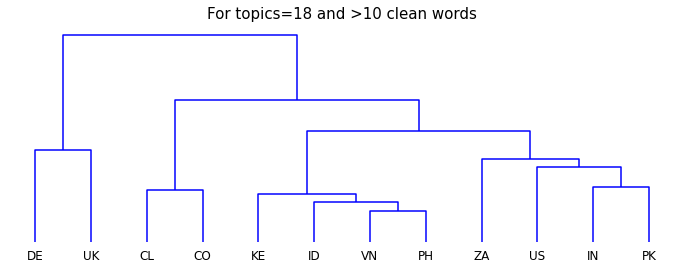

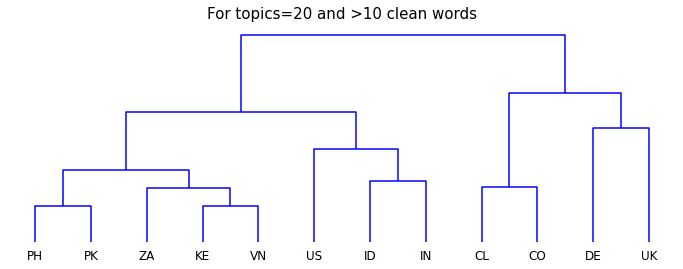

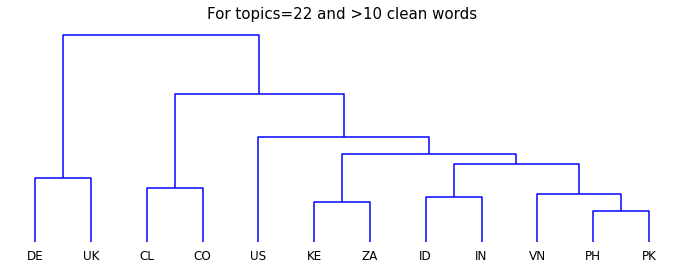

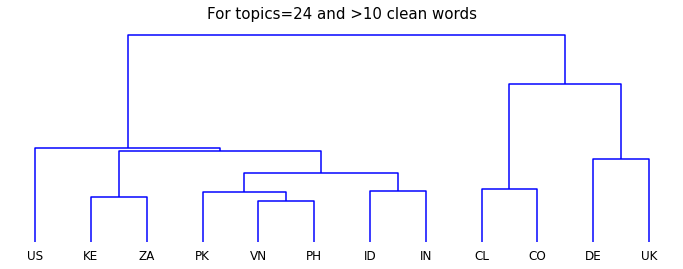

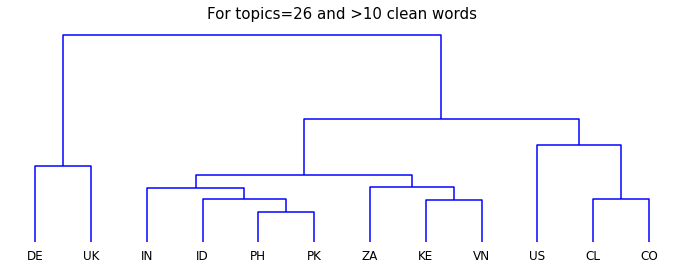

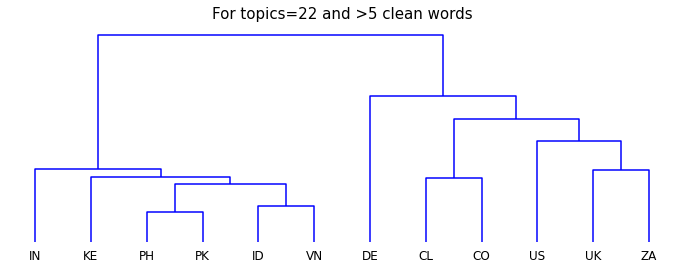

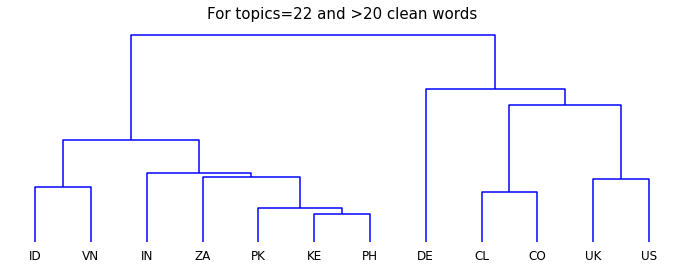

In [118]:
for runs in dict_dict_runs:
    var_drop_x = dict_dict_runs[runs]['var_drop_x']
    var_no_topics_run = dict_dict_runs[runs]['var_no_topics']
    df_distance_p1_run = dict_distance_p1_runs[runs]
    
    fig, ax1 = plt.subplots(figsize=(12,4))
    #remove spines
    for x in ['top', 'bottom', 'right', 'left']: 
        ax1.spines[x].set_visible(False) 
    Z = shc.linkage(df_distance_p1_run, method ='ward')
    Dendrogram = shc.dendrogram(Z, labels=list_country_oder, color_threshold=1)
    #remove ticks and labels on the y axis
    ax1.tick_params(left = False, labelleft = False)
    ax1.set_title('For topics='+str(var_no_topics_run)+' and >'+str(var_drop_x)+' clean words', fontsize=var_text_size)
    #save
    for file_type in ['svg', 'png']:
        plt.savefig('.//results//z_compare_clustering_para//'+runs+'_df_distance_p1_'+timestr+'_V01.'+file_type, \
                       bbox_inches="tight")
    plt.show()